### Predicting Tennis Players' Ranks Based on Physical Attributes

If you know a bit about tennis, you've likely heard of Roger Federer. World famous tennis player Roger Federer, who achieved a peak rank of number 1, is a true tennis genius. From our dataset, we know that he is right-handed, and he uses one hand to hit backhand shots. Could Federer’s success be due to which hand or how many hands he uses? Or might it depend on other factors like height and weight? We will examine player statistics to investigate these questions. The dataset we will use is “Player Stats for Top 500 Players” from https://www.ultimatetennisstatistics.com. Using this dataset, we will attempt to build a model to predict a new player’s success in professional tennis.

#### Methods

We first perform some preliminary summarization and analysis of the data.

In [1]:
# loading libraries

library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

options(repr.matrix.max.rows = 7)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

First, we read in our data. We select variables of interest, then tidy it, formatting cells to remove parenthetical information and units of measurement.

In [2]:
## reading data (from https://www.ultimatetennisstatistics.com/)

tennis_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

## organizing/tidying data

colnames(tennis_data) <- make.names(colnames(tennis_data))

tennis <- tennis_data |>
            select(Current.Rank, Age, Height, Weight, Plays, Backhand, Favorite.Surface) |> # select relevant variables
            mutate(across(everything(), function(col) {gsub(" .*", "", col)})) |> # format cells
            mutate(across(Current.Rank:Weight, as.numeric)) |> # convert chr to dbl
            mutate(across(Plays:Favorite.Surface, as.factor)) # convert chr to fct

# tennis <- tennis_data |>
#             select(Current.Rank, Age, Height) |> # select relevant variables
#             mutate(across(everything(), function(col) {gsub(" .*", "", col)})) |> # format cells
#             mutate(across(Current.Rank:Height, as.numeric)) |> # conver chr to dbl
#             drop_na() # remove observations with missing values

tennis

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Current.Rank,Age,Height,Weight,Plays,Backhand,Favorite.Surface
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
378,26,NA,NA,Right-handed,NA,NA
326,18,NA,NA,Left-handed,Two-handed,NA
178,32,185,NA,Right-handed,Two-handed,Fast
236,21,NA,NA,Right-handed,Two-handed,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮
495,23,NA,NA,Left-handed,NA,NA
419,24,NA,NA,NA,NA,NA
451,22,NA,NA,Left-handed,Two-handed,NA


We split our data into a training and testing set so that we may evaluate our model's accuracy later.

In [3]:
set.seed(2022)

tennis_split <- initial_split(tennis, prop = 0.75, strata = Current.Rank)

tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

To start, we determine the percentage of missing values for each variable, as well as calculate the means for numerical values and modes for factor values.

In [4]:
## exploratory data analysis

# calculating missing percentages

missing_num <- tennis_training |>
                select(where(is.numeric)) |>
                pivot_longer(everything(), names_to = "var", values_to = "val") |>
                mutate(missing = is.na(val)) |>
                group_by(var, missing) |>
                summarise(n = n()) |>
                mutate(percentage_missing = (n / nrow(tennis)) * 100)

missing_fct <- tennis_training |>
                select(where(is.factor)) |>
                pivot_longer(everything(), names_to = "var", values_to = "val") |>
                mutate(missing = is.na(val)) |>
                group_by(var, missing) |>
                summarise(n = n()) |>
                mutate(percentage_missing = n / nrow(tennis) * 100)

missing_all <- bind_rows(missing_num, missing_fct) |>
                filter(missing) |>
                select(var, percentage_missing)

# summary statistics

summary_num <- tennis_training |>
                select(where(is.numeric)) |>
                summarize_all(mean, na.rm = TRUE)

find_mode <- function(v) # calculates mode of given vector
{
    tibble(var = v, y = 0) |>
        na.omit() |>
        group_by(var) |>
        summarize(n = n()) |>
        slice_max(n) |>
        select(var) |>
        pull()
}

summary_fct <- tennis_training |>
                select(where(is.factor)) |>
                summarize_all(find_mode)

summary_all <- bind_cols(summary_num, summary_fct)

missing_all # shows percentage of missing values for each variable (some have very high % missing)
summary_all # shows summary statistics for each variable; means of numeric, modes of factors

`summarise()` has grouped output by 'var'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'var'. You can override using the `.groups`
argument.


var,percentage_missing
<chr>,<dbl>
Age,0.2
Current.Rank,0.8
Height,56.8
Weight,71.6
Backhand,14.0
Favorite.Surface,38.0
Plays,6.4


Current.Rank,Age,Height,Weight,Plays,Backhand,Favorite.Surface
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
248.2683,26.05376,186.236,84.46667,Right-handed,Two-handed,Clay


As the weight variable simply has too many missing values, we will discard it.

Now, we visualize potential correlations between the rest of the variables and current rank.

In [5]:
## data visualization

# defining variables/functions

point_alpha <- 0.6
point_size <- 2.5

theme_layer <- theme(text = element_text(size = 20))

set_size <- function(p)
{
    switch(
        p,
        "age" = options(repr.plot.width = 8, repr.plot.height = 7),
        "height" = options(repr.plot.width = 7, repr.plot.height = 6)
    )
}

Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 299 rows containing missing values (geom_point).”


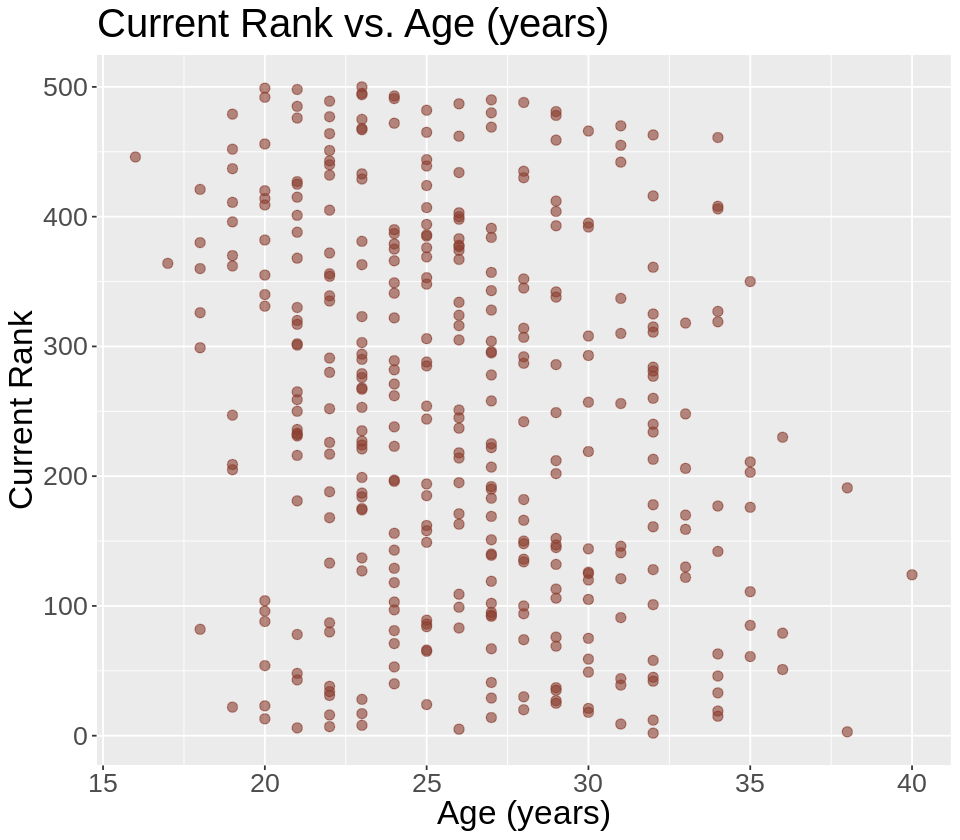

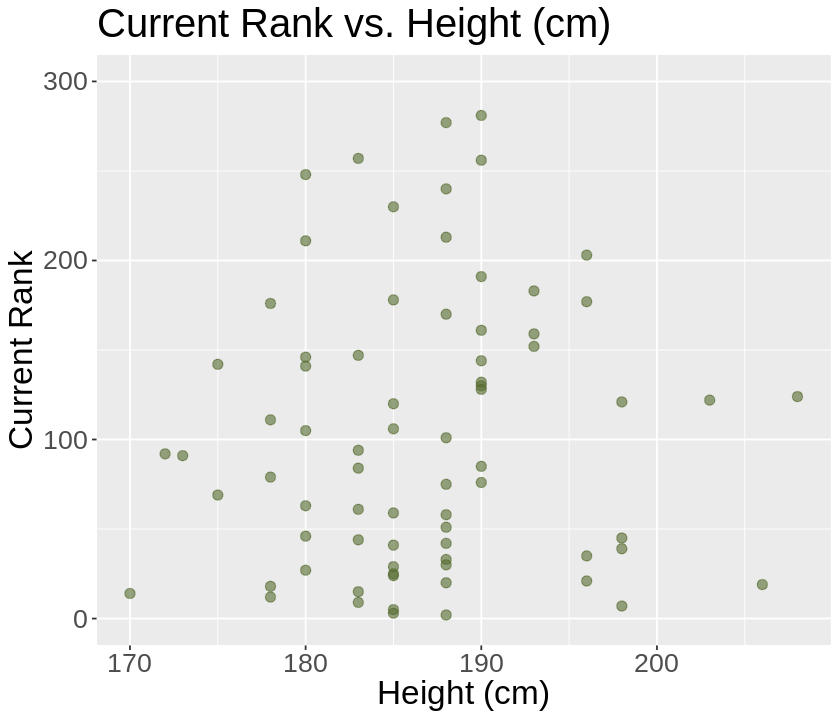

In [6]:
# plotting variables of interest against current rank

age_plot <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank)) +
                geom_point(alpha = point_alpha, colour = "coral4", size = point_size) +
                labs(x = "Age (years)", y = "Current Rank") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank)) +
                geom_point(alpha = point_alpha, colour = "darkolivegreen", size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

set_size("age")
age_plot
set_size("height")
height_plot

The current rank vs age plot seems to show a very weak negative relationship. <br>
The current rank vs height plot very loosely takes on the shape of a normal distribution. <br>

Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 299 rows containing missing values (geom_point).”


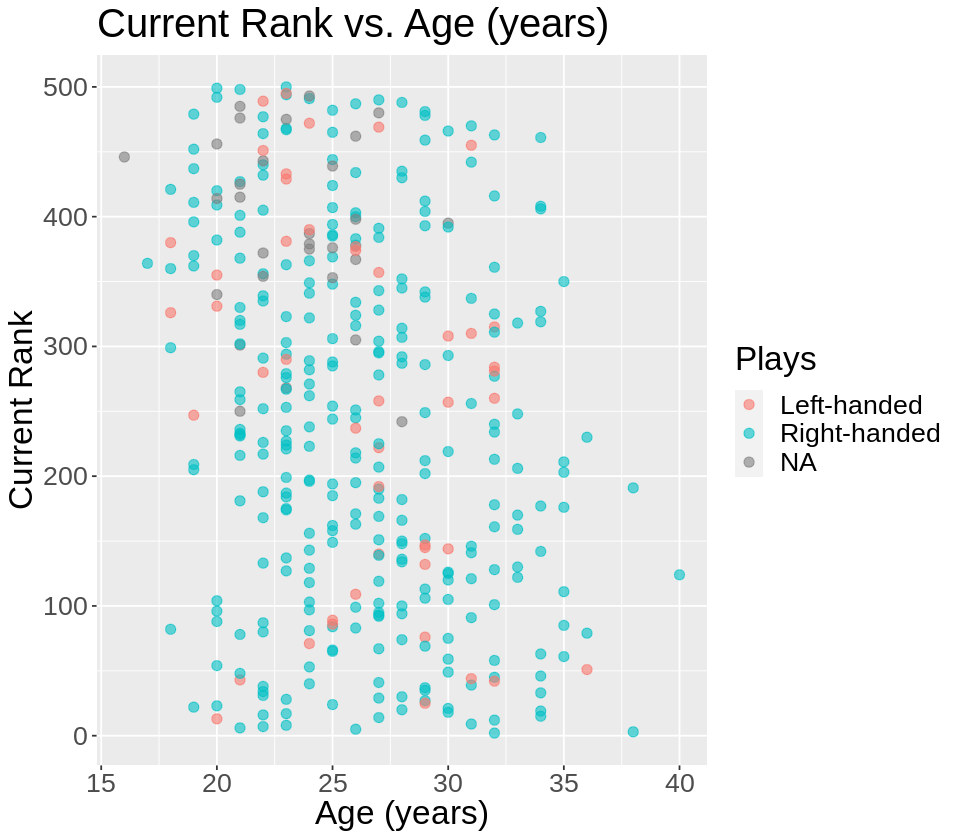

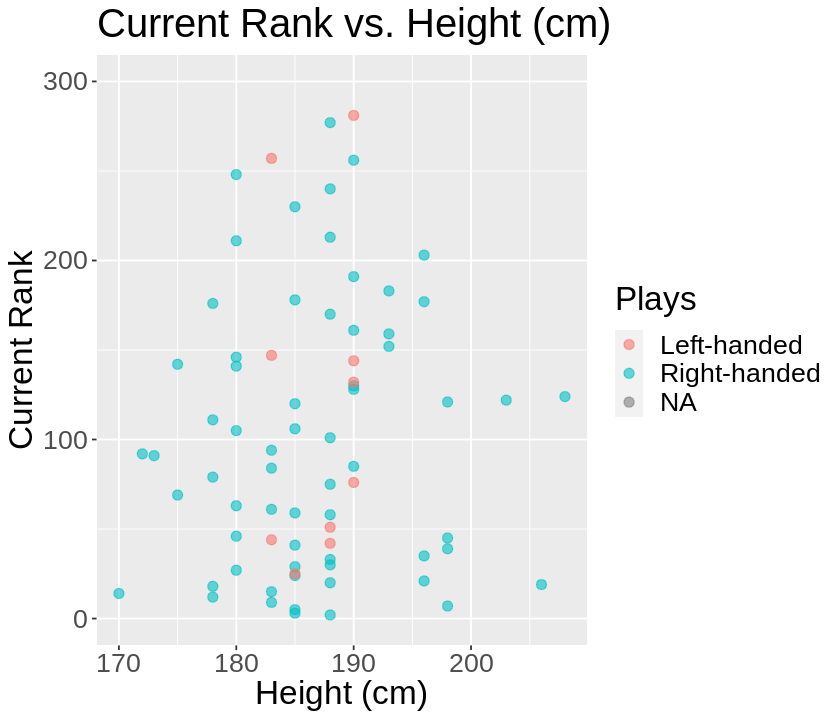

In [7]:
# colouring by handedness

age_plot_c_p <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank, colour = Plays)) +
                geom_point(alpha = point_alpha, size = point_size) +
                labs(x = "Age (years)", y = "Current Rank") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot_c_p <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank, colour = Plays)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

set_size("age")
age_plot_c_p
set_size("height")
height_plot_c_p

Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 299 rows containing missing values (geom_point).”


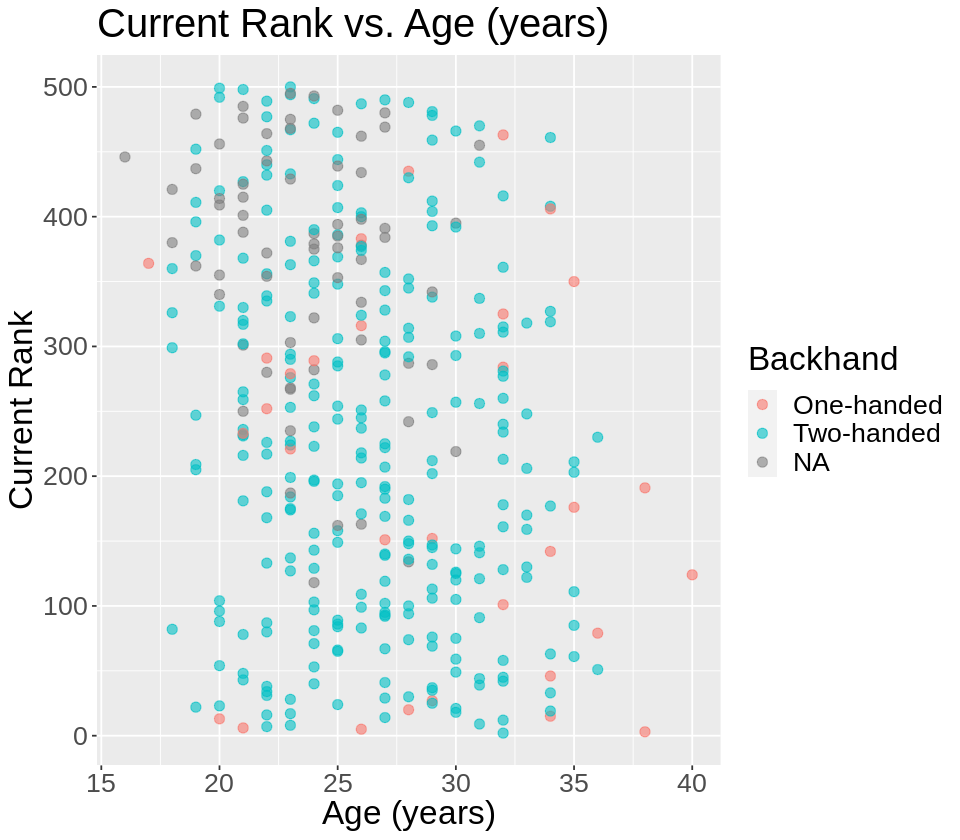

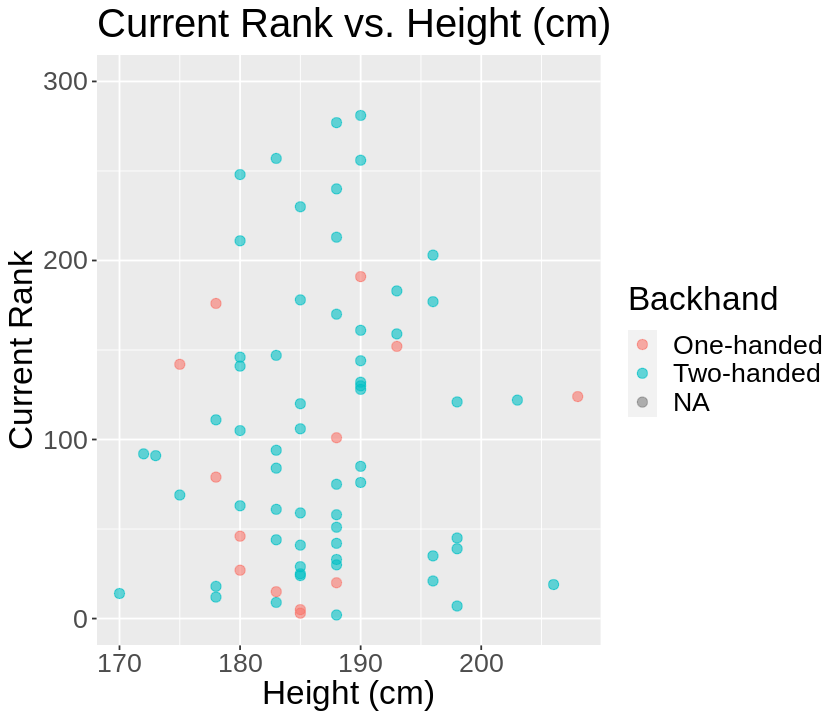

In [8]:
# colouring by backhand

age_plot_c_bh <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank, colour = Backhand)) +
                geom_point(alpha = point_alpha, size = point_size) +
                labs(x = "Age (years)", y = "Current Rank") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot_c_bh <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank, colour = Backhand)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

set_size("age")
age_plot_c_bh
set_size("height")
height_plot_c_bh

Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 299 rows containing missing values (geom_point).”


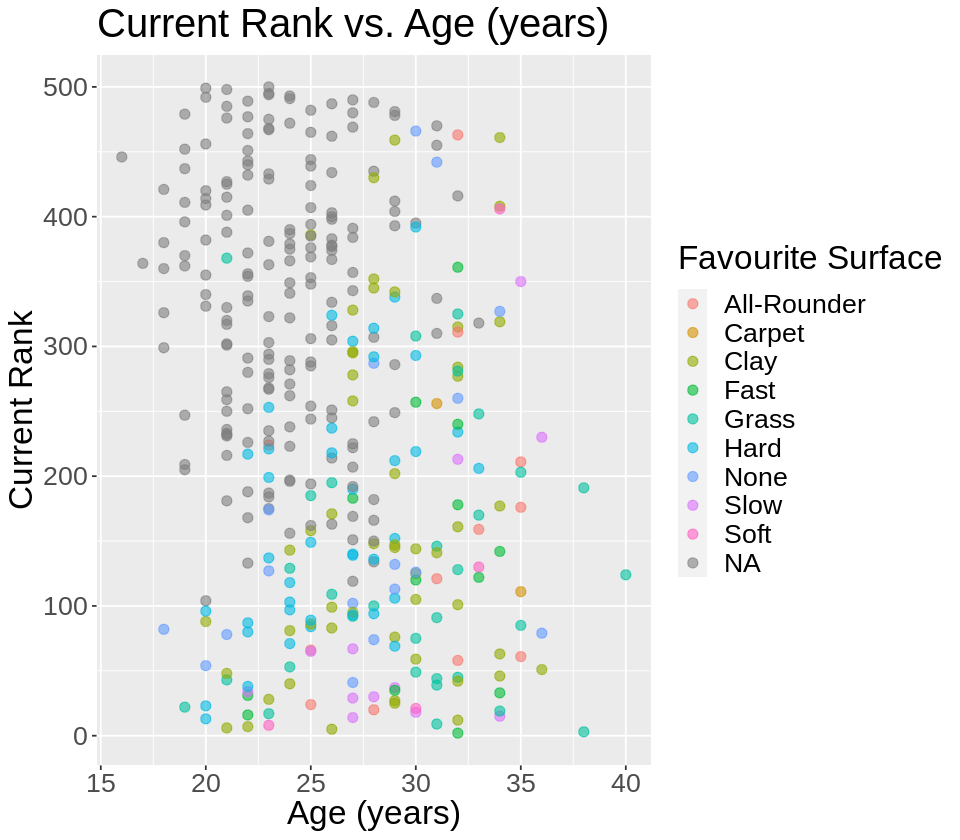

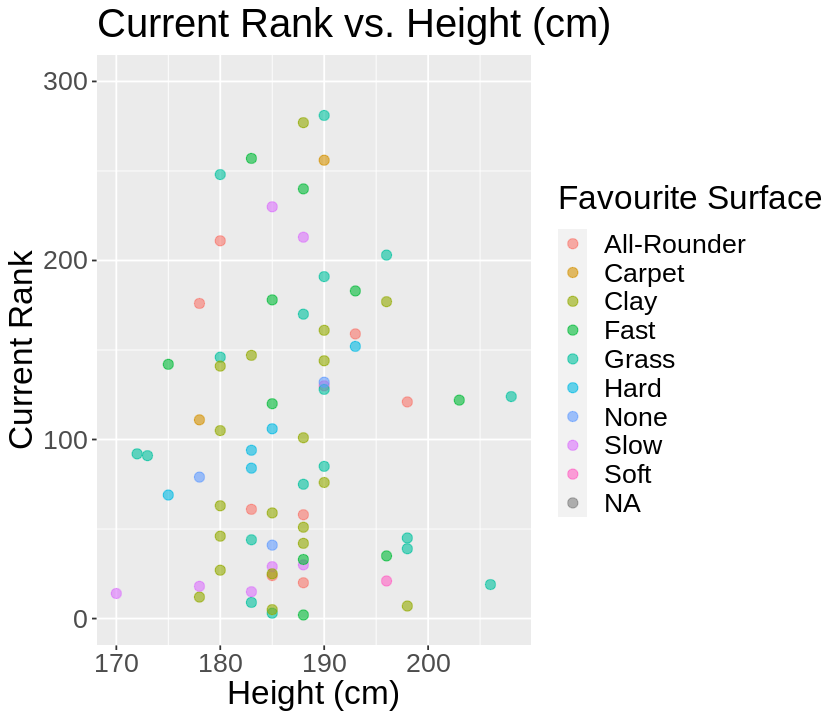

In [9]:
# colouring by favourite surface

age_plot_c_fs <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank, colour = Favorite.Surface)) +
                geom_point(alpha = point_alpha, size = point_size) +
                labs(x = "Age (years)", y = "Current Rank", colour = "Favourite Surface") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot_c_fs <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank, colour = Favorite.Surface)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank", colour = "Favourite Surface") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

set_size("age")
age_plot_c_fs
set_size("height")
height_plot_c_fs

Analyzing the coloured plots, there does not seem to be any correlation between current rank and handedness, backhand, or favourite surface, and so we discard those as well.

In [10]:
tennis_training <- select(tennis_training, Current.Rank, Age, Height) |> drop_na()
tennis_testing <- select(tennis_testing, Current.Rank, Age, Height) |> drop_na()
tennis_training
tennis_testing

Current.Rank,Age,Height
<dbl>,<dbl>,<dbl>
121,31,198
45,32,198
105,30,180
12,32,178
⋮,⋮,⋮
392,30,183
430,28,183
459,29,178


Current.Rank,Age,Height
<dbl>,<dbl>,<dbl>
32,29,175
1,33,185
255,32,185
180,31,180
⋮,⋮,⋮
138,29,193
108,27,180
179,34,183


We will use K-nearest neighbors regression to predict tennis players' ranks. Regression will be used because we will be predicting a numerical variable. This model works best with our data because we plan to use multiple predictors in our analysis, creating a non-linear relationship between our variables.

As part of our preliminary analysis, it was found that age and height were the predictors that showed the most correlation with rank. Other variables we initially intended to use either did not seem to display any significant relationship with rank (handedness, backhand, favourite surface) or did not have enough data points (weight).

In order to achieve the best results, we will create and test several models with different combinations of our variables of interest (age and height), and select the combination which yields the highest accuracy.

First we will use only age.

In [11]:
set.seed(2022)

# Predictors: age
# model, recipe, cross-validation

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>  
            set_engine("kknn") |>  
            set_mode("regression")

tennis_age_recipe <- recipe(Current.Rank ~ Age, data = tennis_training) |>  
            step_scale(all_predictors()) |>  
            step_center(all_predictors())

tennis_age_vfold <- vfold_cv(tennis_training, v = 5, strata = Current.Rank)

tennis_age_wkflw <- workflow() |>  add_recipe(tennis_age_recipe) |>  add_model(knn_spec)

# gridvals <- tibble(neighbors = seq(1, 66))

tennis_age_results <- tennis_age_wkflw |>
             tune_grid(resamples = tennis_age_vfold, grid = 65) |>
             collect_metrics() |>
             filter(.metric == "rmse")

tennis_age_min <- tennis_age_results |> filter(mean == min(mean))
tennis_age_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,rmse,standard,131.5651,5,5.682429,Preprocessor1_Model13


In [12]:
# Retrain data on training set, then predict with testing

# re-train KNN regression model on the training data set
tennis_age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>  
            set_engine("kknn") |>  
            set_mode("regression")

tennis_age_fit <- workflow() |>  
        add_recipe(tennis_age_recipe) |>  
        add_model(tennis_age_spec) |>  
        fit(data = tennis_training)

# predict rmpse with testing
tennis_age_rmspe <- tennis_age_fit |>  
            predict(tennis_testing) |>  
            bind_cols(tennis_testing) |>  
            metrics(truth = Current.Rank, estimate = .pred) |>  
            filter(.metric == 'rmse') |>
            select(.estimate) |>
            pull()

tennis_age_rmspe

[1] 94.5684

Next, we use only height.

In [13]:
set.seed(2022)

# Predictors: height
# model, recipe, cross-validation 

tennis_height_recipe <- recipe(Current.Rank ~ Height, data = tennis_training) |>  
            step_scale(all_predictors()) |>  
            step_center(all_predictors())

tennis_height_vfold <- vfold_cv(tennis_training, v = 5, strata = Current.Rank)

tennis_height_wkflw <- workflow() |>  add_recipe(tennis_height_recipe) |>  add_model(knn_spec)

#gridvals <- tibble(neighbors = seq(1, 66))

tennis_height_results <- tennis_height_wkflw |>
             tune_grid(resamples = tennis_height_vfold, grid = 65) |>
             collect_metrics() |>
             filter(.metric == "rmse")

tennis_height_min <- tennis_age_results |>  filter(mean == min(mean))
tennis_height_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,rmse,standard,131.5651,5,5.682429,Preprocessor1_Model13


In [14]:
#re-train KNN regression model on the training data set
tennis_height_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>  
            set_engine("kknn") |>  
            set_mode("regression")

tennis_height_fit <- workflow() |>  
        add_recipe(tennis_height_recipe) |>  
        add_model(tennis_height_spec) |>  
        fit(data = tennis_training)

#predict rmpse with testing
tennis_height_rmspe <- tennis_height_fit |>  
            predict(tennis_testing) |>  
            bind_cols(tennis_testing) |>  
            metrics(truth = Current.Rank, estimate = .pred) |>  
            filter(.metric == 'rmse') |>
            select(.estimate) |>
            pull()

tennis_height_rmspe

[1] 103.6807

Finally, we will construct a model using both age and height.

In [15]:
set.seed(2022)

# Predictors: age and height

tennis_both_recipe <- recipe(Current.Rank ~ Age + Height, data = tennis_training) |>  
            step_scale(all_predictors()) |>
            step_center(all_predictors())

tennis_both_vfold <- vfold_cv(tennis_training, v = 5, strata = Current.Rank)

tennis_both_wkflw <- workflow() |>  add_recipe(tennis_both_recipe) |>  add_model(knn_spec)

#gridvals <- tibble(neighbors = seq(1, 66))

tennis_both_results <- tennis_both_wkflw |>
             tune_grid(resamples = tennis_both_vfold, grid = 65) |>
             collect_metrics() |>
             filter(.metric == "rmse")

tennis_both_min <- tennis_both_results |>  filter(mean == min(mean))
tennis_both_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,rmse,standard,128.1108,5,6.185088,Preprocessor1_Model15


In [16]:
# re-train KNN regression model on the training data set
tennis_both_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>  
            set_engine("kknn") |>  
            set_mode("regression")

tennis_both_fit <- workflow() |>  
        add_recipe(tennis_both_recipe) |>  
        add_model(tennis_both_spec) |>  
        fit(data = tennis_training)

#predict rmpse with testing
tennis_both_rmspe <- tennis_both_fit |>  
            predict(tennis_testing) |>  
            bind_cols(tennis_testing) |>  
            metrics(truth = Current.Rank, estimate = .pred) |>  
            filter(.metric == 'rmse') |>
            select(.estimate) |>
            pull()
tennis_both_rmspe

[1] 95.0943

We see that using only age as the predictor gives us the smallest root mean square prediction error (RMSPE). Therefore, we will model the predictions of current rank using only age.

Plotting our predictions:

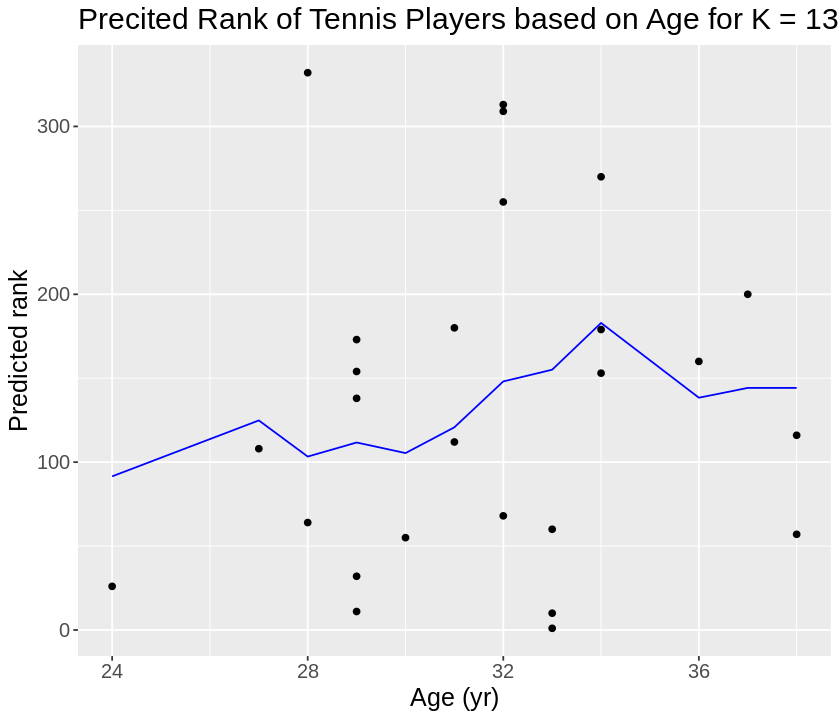

In [24]:
#plot for rank vs age 
tennis_age_preds <- tennis_age_fit |>  
            predict(tennis_testing) |>  
            bind_cols(tennis_testing)

tennis_age_plot <- tennis_age_preds |>
    ggplot(aes(x = Age, y = Current.Rank)) +
    geom_point() +
    geom_line(data = tennis_age_preds,
              aes(x = Age, y = .pred),
              color = "blue") +
    labs(x = "Age (yr)", y = "Predicted rank") +
    ggtitle(paste0("Precited Rank of Tennis Players based on Age for K = ", 13)) +
    theme(text = element_text(size = 15))

tennis_age_plot

In [25]:
#We see that using both the age and height predictors together gives us the smallest root mean square prediction error (RMSPE). 
#Therefore, we will model the predictions of current rank using both height and age predictor variables.

# Age only actually gives the best accuracy

In [26]:
#To expand our analysis, we will also plot the prediction rank of the height variable and generate a 3D Plot to visualize both predictor variables together 

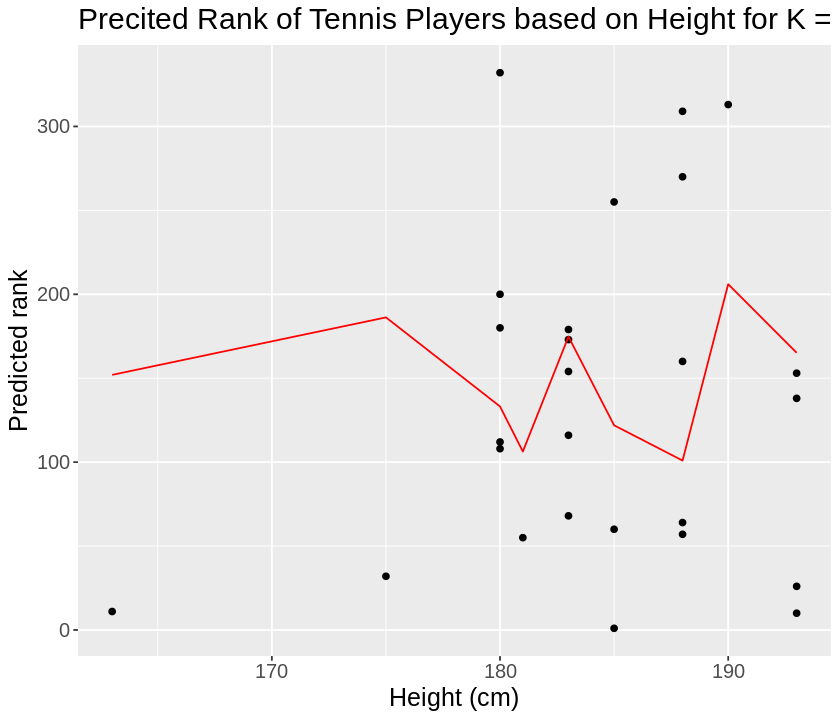

In [29]:
#plot of rank vs height
tennis_height_preds <- tennis_height_fit |>  
            predict(tennis_testing) |>  
            bind_cols(tennis_testing)

tennis_height_plot <- tennis_height_preds |>
    ggplot(aes(x = Height, y = Current.Rank)) +
    geom_point() +
    geom_line(data = tennis_height_preds,
              aes(x = Height, y = .pred),
              color = "red") +
    labs(x = "Height (cm)", y = "Predicted rank") +
    ggtitle(paste0("Precited Rank of Tennis Players based on Height for K = ", 13)) +
    theme(text = element_text(size = 15))

tennis_height_plot

In [30]:
#3D Plot of rank vs height and age (both predictors)

#### Discussion

1. summarize what you found
2. discuss whether this is what you expected to find?
3. discuss what impact could such findings have?
4. discuss what future questions could this lead to?

1
By using the k-nearest neighbor regression algorithm, we were able to determine an estimated accuracy of how effectively our model predicts a player’s rank based on their physical attributes. We found that the age predictor gave us the lowest Root Mean Square Prediction Error and hence, provides the bst accuracy when looking at the Current Rank. When looking at the original data for age, only 0.2% was missing, height had 56.8% missing and Current Rank had 0.8% missing. This suggests that the age variable may be the easiest to determine when gathering player statistics. Following this, the fac that the age predictor alone gave us the best accuracy gives confidence that it is likely possible to predict a possible rank for mostly any player that comes into the tennis field as the age variable is almost guranteed to be known. 

2
In our preliminary analysis, we excepted to find that older players (negative correlation in age) will have higher ranks as well as players who are average in height, will more likely have lower ranks (based on the normal distribution of height). Our findings show that 

3

Depending on the model’s prediction accuracy, the findings can help us predict how well a new player will perform based on the variables of age and height. This readily available information can be helpful for companies and coaches scouting for future talent in the sport of tennis. With a model presenting good accuracy, one is able to look out for specific qualities that suggest a player is good enough to attain a high rank which will benefit personal interests and the sport as a whole. There are many potential studies that may build upon our work in the future.

4
How influential is each attribute in relation to a player’s rank? Which predictor shows the most impact? Are there other variables that may have a direct correlation with rank, such as country? One can also explore whether ethnic background or how many seasons a current player has played will impact the regression model. Furthermore, one can later determine how the age and height predictors will change the model’s accuracy when applied to players of other sports such as badminton or hockey.

#### References

We need "at least 2 citations of literature relevant to the project," and we also need to cite the dataset here.